# CREATING A INTELLIGENT AGENT TO PLAY FLAPPY BIRD

## SETTING THE ENVIRONMENT

Importing the pertinent libraries:

In [1]:
import random
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.inspection import DecisionBoundaryDisplay

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

## EXPLORATORY DATA ANALYSIS

Loading the data:

In [2]:
data = pd.read_csv('../flappy_bean/data/flight_bean.csv')

data.head()

,x,y,label
0,518.5,-195.5,False
1,516.0,-207.5,False
2,515.0,-218.0,False
3,506.0,-239.5,False
4,498.5,-259.5,False


General dataset information:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20863 entries, 0 to 20862
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       20863 non-null  float64
 1   y       20863 non-null  float64
 2   label   20863 non-null  bool   
dtypes: bool(1), float64(2)
memory usage: 346.5 KB


Transforming variables into numerical values and balancing the data:

In [4]:
data.label = data.label.map({False : 0, True : 1})

sampler = RandomUnderSampler()
data, _ = sampler.fit_resample(data, data.label)

Reduction of 17413 samples with label 0:

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3450 entries, 10749 to 20854
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       3450 non-null   float64
 1   y       3450 non-null   float64
 2   label   3450 non-null   int64  
dtypes: float64(2), int64(1)
memory usage: 107.8 KB


Checking the data graphically:

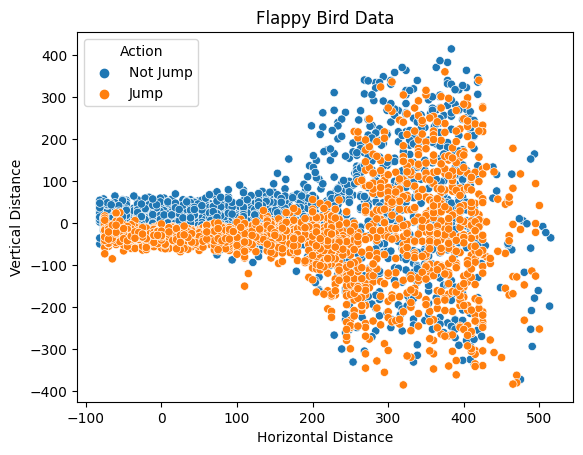

In [6]:
data['Action'] = data['label'].map({0 : 'Not Jump',
                                    1 : 'Jump'})

sns.scatterplot(data=data, x='x', y='y', hue='Action')

plt.title('Flappy Bird Data')
plt.xlabel('Horizontal Distance')
plt.ylabel('Vertical Distance')

plt.show()

Preparing the data for training:

Obs.: Since we'll be testing the models in the game's own environment, we won't split the data between training and testing.

In [7]:
X = data[['x', 'y']]
y = data.label

X_train = X.to_numpy()
y_train = y.to_numpy()

## DECISION TREE CLASSIFIER

Training a decision tree model:

In [8]:
clf = DecisionTreeClassifier(max_depth=10)
ccp_alphas = clf.cost_complexity_pruning_path(X_train, y_train).ccp_alphas

n_alphas = 20
param_grid = {'ccp_alpha' : random.choices(ccp_alphas, k=n_alphas)}

CV_clf_tree = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5)
CV_clf_tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=10),
             param_grid={'ccp_alpha': [0.0007239307175680443,
                                       0.0002889047279638873,
                                       0.0002536231884057971,
                                       0.0002889047279638873,
                                       0.0008900368097248673,
                                       0.0012878027539994067,
                                       0.0011496613482347012,
                                       0.0006688963210702342,
                                       0.0010590858416945374,
                                       0.00023506229341470342,
                                       0.0005617019119006639,
                                       0.0004179221823703055,
                                       0.0008026755852842809,
                                       0.0005617019119006639,
                                       0.0007337288146921431,
                                       0.0036102134058360984,
                                       0.0008026755852842809,
                                       0.00028202115158636925,
                                       0.00027777777777777794,
                                       0.0003091787439613527]})

Evaluating the results:

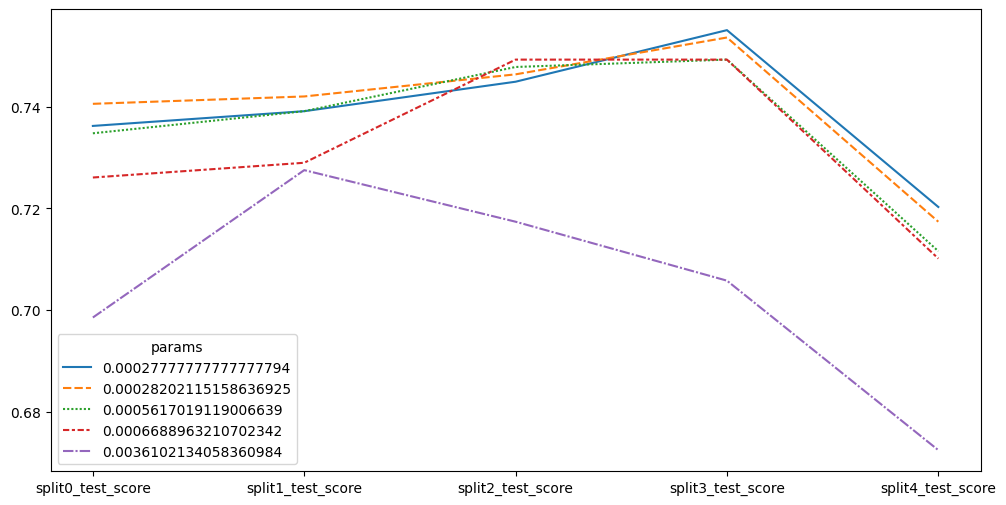

In [9]:
res = pd.DataFrame(CV_clf_tree.cv_results_)
res = res.sort_values(by=['rank_test_score'])
res = res.set_index(res['params'].apply(lambda x: x['ccp_alpha']))

plt.figure(figsize=(12, 6))

sns.lineplot(res.transpose().iloc[6:11, np.linspace(0, res.shape[0]-1, 5, dtype='int64')])

plt.show()

In [10]:
print("Getting the relevants features:")

print()

for i, v in enumerate(CV_clf_tree.best_estimator_.feature_importances_):
    if v:
        print(f"X[{i}] = {data.columns[i]} ({v})")

Getting the relevants features:

X[0] = x (0.3716241670536998)
X[1] = y (0.6283758329463002)


In [11]:
print("Analyzing the results obtained with DecisionTreeClassifier:")

print()
print(f"Best parameters: {CV_clf_tree.best_estimator_}")

print()
print(f"Ein = {(1 - CV_clf_tree.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, CV_clf_tree.predict(X_train)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_train, CV_clf_tree.predict(X_train)))

Analyzing the results obtained with DecisionTreeClassifier:

Best parameters: DecisionTreeClassifier(ccp_alpha=0.00028202115158636925, max_depth=10)

Ein = 20.14%

         h(x)=0  h(x)=+1
f(x)=0     1185      540
f(x)=+1     155     1570

              precision    recall  f1-score   support

           0       0.88      0.69      0.77      1725
           1       0.74      0.91      0.82      1725

    accuracy                           0.80      3450
   macro avg       0.81      0.80      0.80      3450
weighted avg       0.81      0.80      0.80      3450



At this point, we can see:

- The regularization parameter made little difference in the outcome of the training (demonstrating the quality of the data)
- The vertical distance was more relevant (it determines the collision with the pipes and therefore with greater importance for the game)
- Recall 1 of 0.91 demonstrates that when it was supposed to actually jump, the model got it right reasonably

A key aspect in interpreting the model is plotting the decision region:

- As the data collected is limited to the game screen, it is presented in a well-defined way
- It can be seen that the x-axis is mirrored compared to the actual game

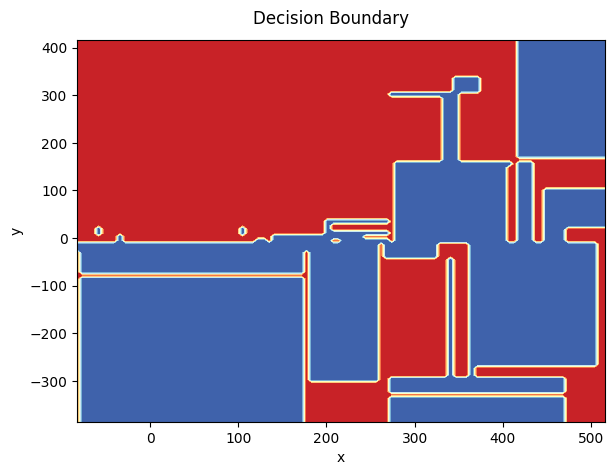

In [12]:
# Displaying the bounding region

clf_tree = CV_clf_tree.best_estimator_

ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    clf_tree,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y'
)

plt.suptitle('Decision Boundary')
_ = plt.axis('tight')

Saving the model:

In [13]:
with open('../flappy_bean/models/dtc.pkl','wb') as f:
    pickle.dump(clf_tree, f)

## SVM

### SVM LINEAR

Training an SVM with linear kernel:

In [14]:
clf_svm = SVC(kernel='linear')
clf_svm.fit(X_train, y_train)

SVC(kernel='linear')

Evaluating the results:

In [15]:
print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"Ein = {(1 - clf_svm.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, clf_svm.predict(X_train)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_train, clf_svm.predict(X_train)))

Analyzing the results obtained with SupportVectorMachine:

Ein = 40.90%

         h(x)=0  h(x)=+1
f(x)=0     1344      381
f(x)=+1    1030      695

              precision    recall  f1-score   support

           0       0.57      0.78      0.66      1725
           1       0.65      0.40      0.50      1725

    accuracy                           0.59      3450
   macro avg       0.61      0.59      0.58      3450
weighted avg       0.61      0.59      0.58      3450



Plotting the decision boundaries and support vectors:

- It can be seen that the decision limits describe a straight line
- The support vectors, in turn, follow the slope of the line

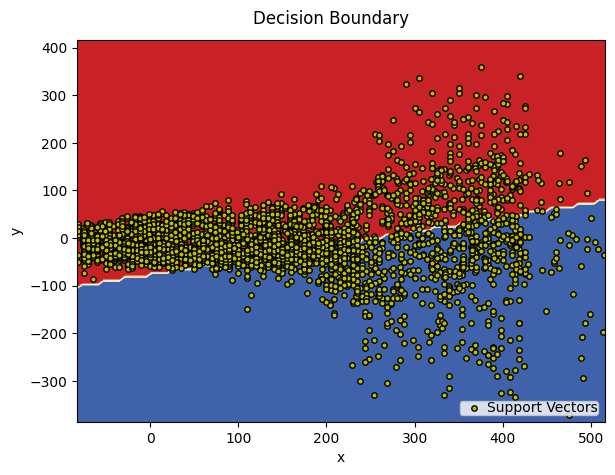

In [16]:
# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    clf_svm,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y'
)

# Displaying the support vectors
plt.scatter(
    clf_svm.support_vectors_[:, 0],
    clf_svm.support_vectors_[:, 1],
    c='y',
    label=f'Support Vectors',
    edgecolor='black',
    s=15
)

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Getting the line found by SVM and plotting together to some samples of the data:

In [17]:
b0 = clf_svm.intercept_[0]
b1, b2 = clf_svm.coef_.squeeze()

f_linear = lambda x: (- b0 - b1*x) / b2

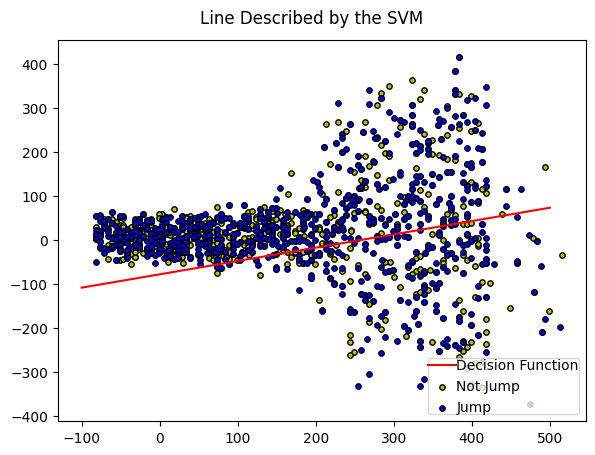

In [18]:
n_classes = 2
plot_colors = 'yb'
n_points = 1500

# Displaying the line described by the SVM
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

x_line = -100, 500
y_line = f_linear(x_line[0]), f_linear(x_line[1])
plt.plot(x_line, y_line, c='red', label='Decision Function')

# Displaying some points of the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y.sample(n=n_points) == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label='Jump' if i else 'Not Jump',
        edgecolor='black',
        s=15
    )


plt.suptitle('Line Described by the SVM')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Saving the model:

In [19]:
with open('../flappy_bean/models/svm_linear.pkl','wb') as f:
    pickle.dump(clf_svm, f)

### SVM RBF

Training an SVM with rbf kernel:

In [20]:
svm_rbf = SVC(kernel='rbf')
svm_rbf.fit(X_train, y_train)

SVC()

Evaluating the results:

In [21]:
print("Analyzing the results obtained with SupportVectorMachine:")

print()
print(f"Ein = {(1 - svm_rbf.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, svm_rbf.predict(X_train)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_train, svm_rbf.predict(X_train)))

Analyzing the results obtained with SupportVectorMachine:

Ein = 28.67%

         h(x)=0  h(x)=+1
f(x)=0      962      763
f(x)=+1     226     1499

              precision    recall  f1-score   support

           0       0.81      0.56      0.66      1725
           1       0.66      0.87      0.75      1725

    accuracy                           0.71      3450
   macro avg       0.74      0.71      0.71      3450
weighted avg       0.74      0.71      0.71      3450



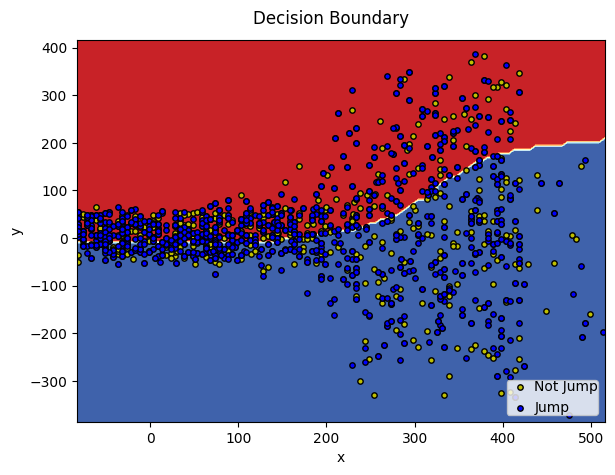

In [22]:
n_classes = 2
plot_colors = 'yb'
n_points = 1500

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    svm_rbf,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y',
)

# Displaying some points of the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y.sample(n=n_points) == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label='Jump' if i else 'Not Jump',
        edgecolor='black',
        s=15
    )

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Obs.: The `rbf` kernel allows the SVM to fit better to the data and thus achieved a better performance in training.

Saving the model:

In [23]:
with open('../flappy_bean/models/svm_rbf.pkl','wb') as f:
    pickle.dump(svm_rbf, f)

## LOGISTIC REGRESSION

Training a logistic regression model:

In [24]:
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)

LogisticRegression()

Evaluating the results:

In [25]:
print("Analyzing the results obtained with LogisticRegression:")

print()
print(f"Ein = {(1 - log_reg.score(X_train, y_train))*100:.2f}%")

print()
print(pd.DataFrame(confusion_matrix(y_train, log_reg.predict(X_train)),
                   index=['f(x)=0', 'f(x)=+1'],
                   columns=['h(x)=0', 'h(x)=+1']))

print()
print(classification_report(y_train, log_reg.predict(X_train)))

Analyzing the results obtained with LogisticRegression:

Ein = 32.38%

         h(x)=0  h(x)=+1
f(x)=0     1232      493
f(x)=+1     624     1101

              precision    recall  f1-score   support

           0       0.66      0.71      0.69      1725
           1       0.69      0.64      0.66      1725

    accuracy                           0.68      3450
   macro avg       0.68      0.68      0.68      3450
weighted avg       0.68      0.68      0.68      3450



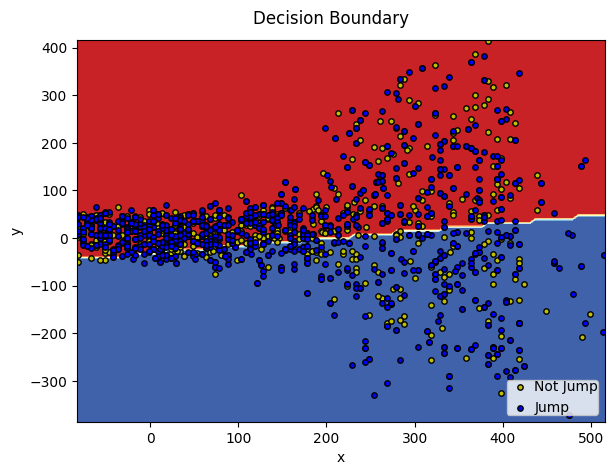

In [26]:
n_classes = 2
plot_colors = 'yb'
n_points = 1500

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)
DecisionBoundaryDisplay.from_estimator(
    log_reg,
    X_train,
    cmap=plt.cm.RdYlBu,
    response_method='predict',
    ax=ax,
    xlabel='x',
    ylabel='y'
)

# Displaying some points of the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y.sample(n=n_points) == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label='Jump' if i else 'Not Jump',
        edgecolor='black',
        s=15
    )

plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Getting the line found by logistic regression:

In [27]:
b0 = log_reg.intercept_[0]
b1, b2 = log_reg.coef_.squeeze()

f_logreg = lambda x: (- b0 - b1*x) / b2

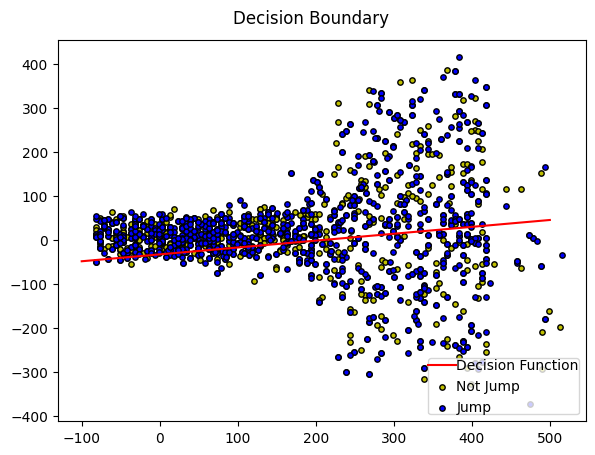

In [28]:
n_classes = 2
plot_colors = 'yb'
n_points = 1500

# Displaying the bounding region
ax = plt.subplot(1, 1, 1)
plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

x_line = -100, 500
y_line = f_logreg(x_line[0]), f_logreg(x_line[1])
plt.plot(x_line, y_line, c='red', label='Decision Function')

# Displaying some points of the data
for i, color in zip(range(n_classes), plot_colors):
    idx = np.where(y.sample(n=n_points) == i)

    plt.scatter(
        X.iloc[idx[0], 0],
        X.iloc[idx[0], 1],
        c=color,
        label='Jump' if i else 'Not Jump',
        edgecolor='black',
        s=15
    )


plt.suptitle('Decision Boundary')
plt.legend(loc='lower right', borderpad=0, handletextpad=0)
_ = plt.axis('tight')

Saving the model:

In [29]:
with open('../flappy_bean/models/log_reg.pkl','wb') as f:
    pickle.dump(log_reg, f)

## INTERPRETING THE RESULTS